## Title: Kknn model to predict Raisin class using classification

## Introduction: 

Write Introduction here...

## Preliminary exploratory data analysis:

#### 1. Demonstrating that the dataset can be read from the web into R 

In [62]:
library(tidyverse)
library(tidymodels)
library(readxl)

In [63]:
raisin_data <- read_csv("https://github.com/dylankim990/DSCI100_Group_2/raw/main/data/Raisin_Dataset.csv")

Parsed with column specification:
cols(
  Area = col_double(),
  MajorAxisLength = col_double(),
  MinorAxisLength = col_double(),
  Eccentricity = col_double(),
  ConvexArea = col_double(),
  Extent = col_double(),
  Perimeter = col_double(),
  Class = col_character()
)



#### 2. Clean and wrangle your data into a tidy format

In [64]:
# tidying was not neccesary since they were in a tidy format
glimpse(raisin_data)
head(raisin_data)

Rows: 900
Columns: 8
$ Area            <dbl> 87524, 75166, 90856, 45928, 79408, 49242, 42492, 6095…
$ MajorAxisLength <dbl> 442.2460, 406.6907, 442.2670, 286.5406, 352.1908, 318…
$ MinorAxisLength <dbl> 253.2912, 243.0324, 266.3283, 208.7600, 290.8275, 200…
$ Eccentricity    <dbl> 0.8197384, 0.8018052, 0.7983536, 0.6849892, 0.5640113…
$ ConvexArea      <dbl> 90546, 78789, 93717, 47336, 81463, 51368, 43904, 6232…
$ Extent          <dbl> 0.7586506, 0.6841296, 0.6376128, 0.6995994, 0.7927719…
$ Perimeter       <dbl> 1184.040, 1121.786, 1208.575, 844.162, 1073.251, 881.…
$ Class           <chr> "Kecimen", "Kecimen", "Kecimen", "Kecimen", "Kecimen"…


Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
87524,442.2460,253.2912,0.8197384,90546,0.7586506,1184.040,Kecimen
75166,406.6907,243.0324,0.8018052,78789,0.6841296,1121.786,Kecimen
90856,442.2670,266.3283,0.7983536,93717,0.6376128,1208.575,Kecimen
45928,286.5406,208.7600,0.6849892,47336,0.6995994,844.162,Kecimen
79408,352.1908,290.8275,0.5640113,81463,0.7927719,1073.251,Kecimen
49242,318.1254,200.1221,0.7773513,51368,0.6584564,881.836,Kecimen


#### 3. Summarizing the data in at least one table

In [65]:
#a) the number of observations in each class
obs_num_class <- raisin_data %>%
    group_by(Class) %>%
    summarize(num_obs = n())

obs_num_class

`summarise()` ungrouping output (override with `.groups` argument)



Class,num_obs
<chr>,<int>
Besni,450
Kecimen,450


In [66]:
#b) the means of the predictor variables you plan to use in your analysis
means_predictors <- raisin_data %>%
    select(-Class) %>%
    map_df(mean)

means_predictors    

Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
87804.13,430.93,254.4881,0.7815422,91186.09,0.6995079,1165.907


In [67]:
#c) counting how many rows have missing data. 
num_of_na <- colSums(is.na(raisin_data))

num_of_na

Area MajorAxisLength MinorAxisLength    Eccentricity      ConvexArea 
              0               0               0               0               0 
         Extent       Perimeter           Class 
              0               0               0

#### 4. Visualizing the data with at least one plot relevant to the analysis

In [68]:
#a) comparing the distributions of each of the predictor variables

## Methods:

#### 1. Process of data analysis

The process of Raisin data analysis uses classification to predict if the test data are either Kecimen or Besni raisin. 

#### 2. Variables/columns to use 

This project used forward selection method to find the accuracy rates for different combinations of predictors and visualized them. 

In [69]:
set.seed(5805)
raisin_split <- initial_split(raisin_data, prop = 0.75 ,strata = Class)
raisin_training <- training(raisin_split)
raisin_testing <- testing(raisin_split)

raisin_subset <- raisin_training %>%
  select(Area,
         MajorAxisLength, 
         MinorAxisLength, 
         Eccentricity, 
         ConvexArea, 
         Extent, 
         Perimeter, 
         Class)

names <- colnames(select(raisin_subset, -Class))

In [70]:
# creating an empty tibble which will store the accuracy results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

In [71]:
# create a model 
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

In [72]:
set.seed(5805)
# 5-fold cross-validation
raisin_vfold <- vfold_cv(raisin_subset, v = 5, strata = Class)

# total # of predictors
n_total <- length(names)

# creating to store selected predictors
selected <- c()

In [73]:
set.seed(5805)
#loops to try all the models
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()

#inner loop for model string for different combinations of predictors
    for (j in 1:length(names)) {
        # create a model string for the combinations of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Class", "~", paste(preds_new, collapse="+"))
        
# created a recipe from the model string
        raisin_recipe <- recipe(as.formula(model_string), 
                                data = raisin_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())
        
# tune the KNN classifier with these predictors, 
# and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(raisin_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = raisin_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

# add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
        accuracies <- accuracies %>% 
          add_row(size = i, 
                  model_string = models[[jstar]], 
                  accuracy = accs[[jstar]])
        selected <- c(selected, names[[jstar]])
        names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Class ~ Perimeter,0.8507902
2,Class ~ Perimeter+Area,0.8597015
3,Class ~ Perimeter+Area+MajorAxisLength,0.8611501
4,Class ~ Perimeter+Area+MajorAxisLength+ConvexArea,0.8611282
5,Class ~ Perimeter+Area+MajorAxisLength+ConvexArea+Eccentricity,0.8654741
6,Class ~ Perimeter+Area+MajorAxisLength+ConvexArea+Eccentricity+Extent,0.8640474
7,Class ~ Perimeter+Area+MajorAxisLength+ConvexArea+Eccentricity+Extent+MinorAxisLength,0.8581870


#### 3.Describing at least one way to visualize the results

Below is the visualization of how estimated accuracy changes as number of predictors changes.

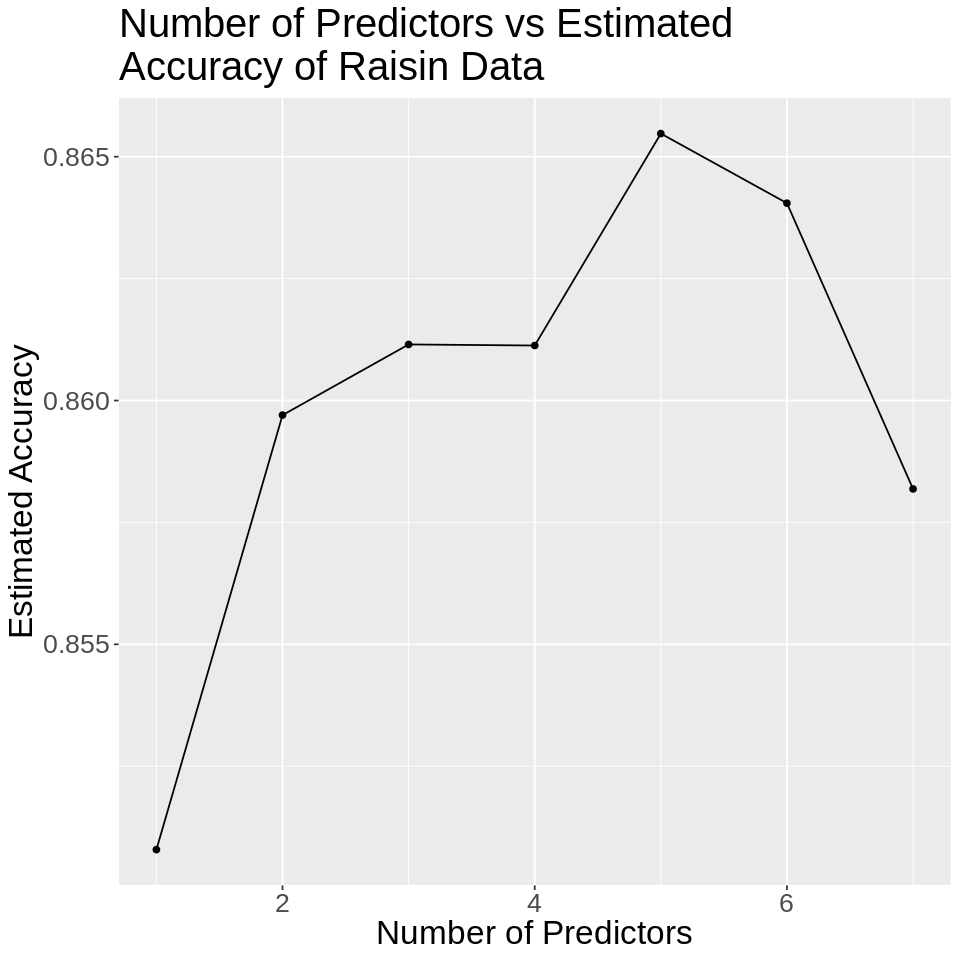

In [74]:
options(repr.plot.width = 8, repr.plot.height = 8)

accuracies_plot <- ggplot(accuracies, aes(x = size, y = accuracy)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Predictors", y = "Estimated Accuracy", title = "Number of Predictors vs Estimated 
Accuracy of Raisin Data") +
    theme(text = element_text(size = 20))

accuracies_plot